In [54]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

In [55]:
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

In [56]:
cleansed=load_amihud_markets_price()

In [57]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

In [58]:
sector_rtns={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_rtns[sect]=np.log(cleansed[d_map[sect]].resample(rule='m',how='last')).diff().dropna(how='all')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  after removing the cwd from sys.path.


# Presentation to be like "Time Varying Liquidity and Momentum Profits (2015) paper

Rank by deciles, HML (8,9,10) - (1,2,3).  Save monthly returns (equal (risk?) weighted) and if you want to annualized then resample.


Then correlation matrix 
* Overall market vol?
* Market illiquidity (median Amihud through time series)


# Amihud (2002) Annual portfolio sorts

In [59]:
data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

# Monthly portfolio sorts

In [60]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,2)

In [61]:
sector_portfolio_sorts_mon={}
for s in sector_zscores.keys():
    sector_portfolio_sorts_mon[s]=quantile_portfolios_monthly(sector_zscores[s],cleansed,10)
sector_portfolio_sorts_mon['All']=quantile_portfolios_monthly(data,cleansed,10)

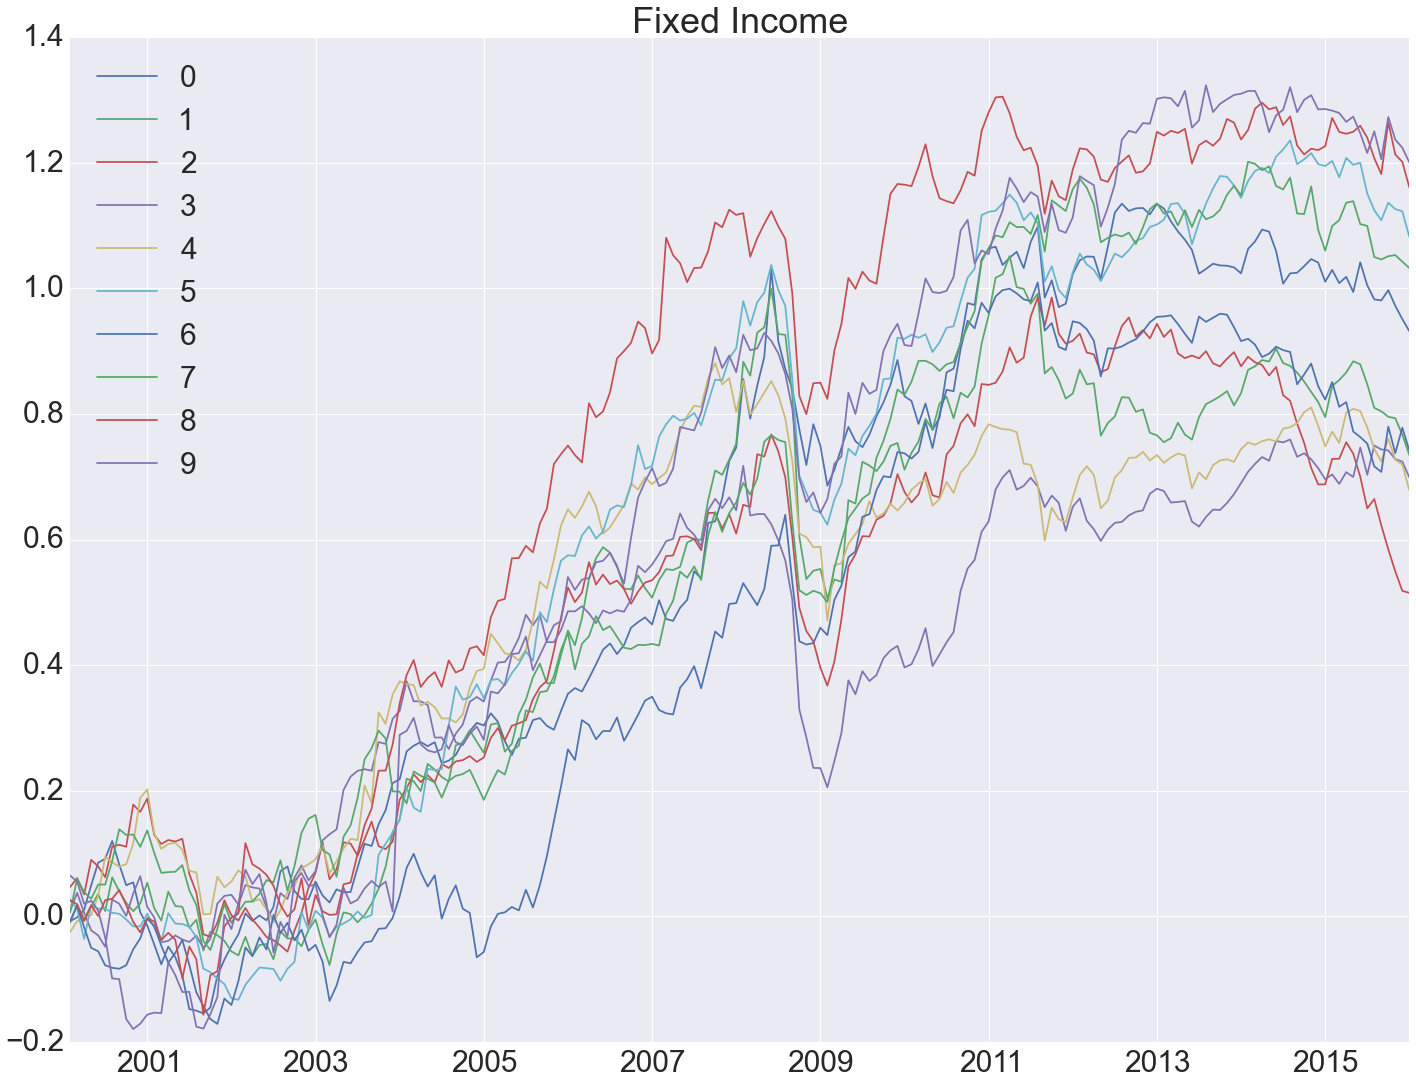

In [62]:
sector_portfolio_sorts_mon['All'].cumsum().plot(title=s)

In [63]:
for s in sector_portfolio_sorts_mon.keys():
    sector_portfolio_sorts_mon[s].to_pickle('data/'+s+'_monthly_10.pickle')


In [64]:
all_factors=pd.DataFrame()
all_factors['Amihud Monthly']=(sector_portfolio_sorts_mon['All']['9']-sector_portfolio_sorts_mon['All']['0'])

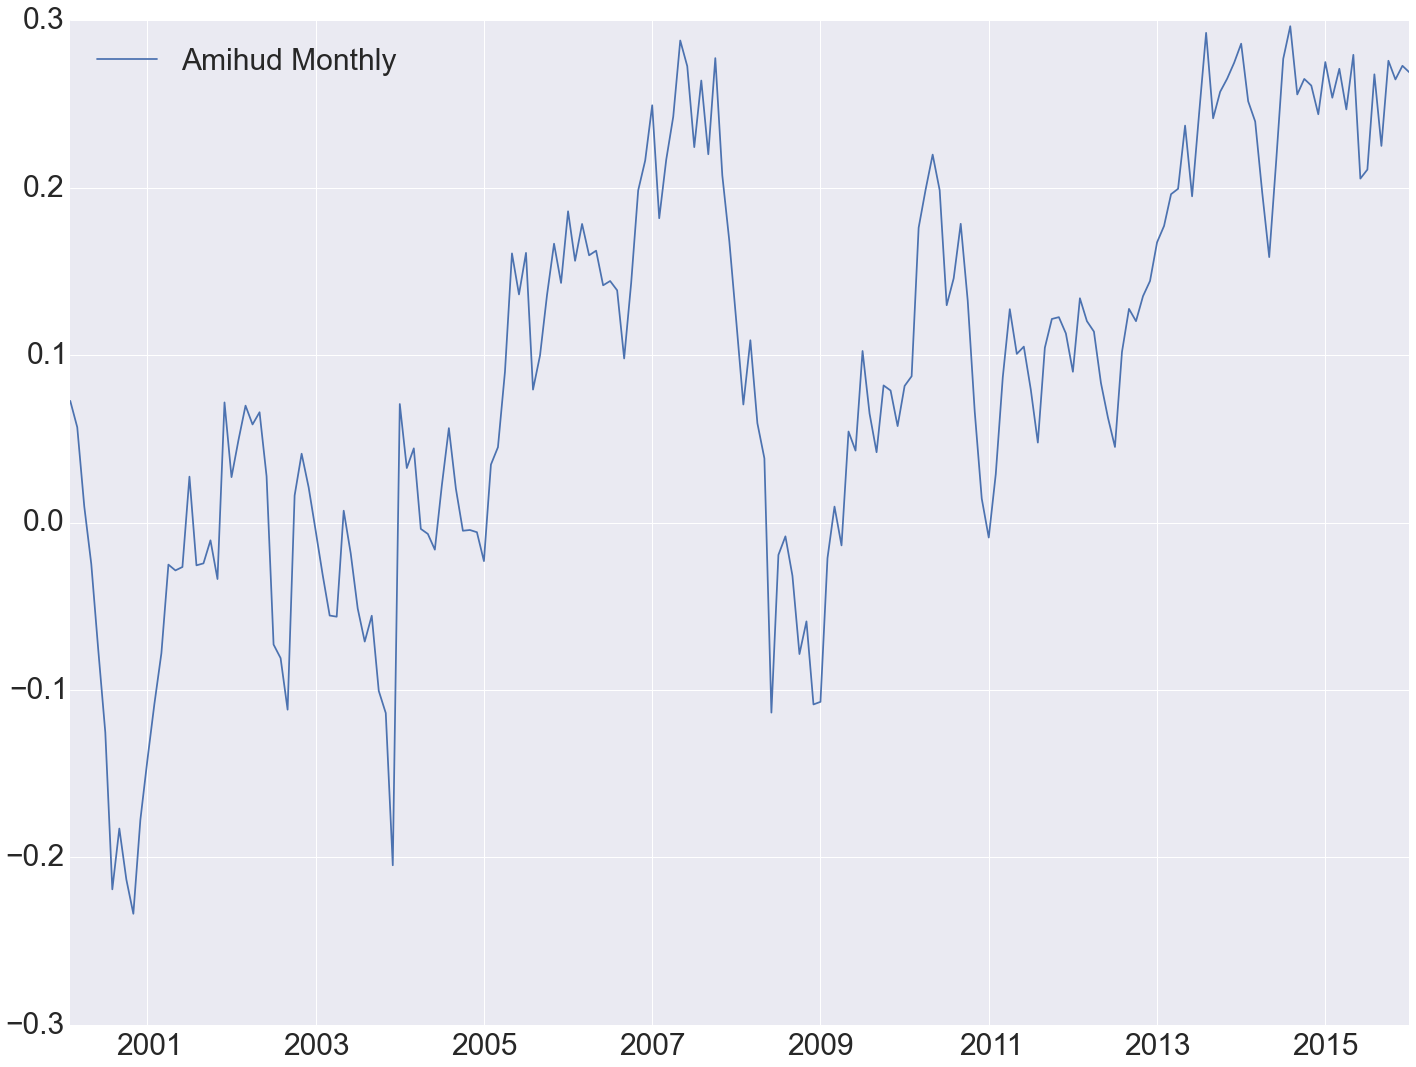

In [65]:
all_factors.cumsum().plot()

In [ ]:
FHT=calculate_FHT(cleansed)
data=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(FHT)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [ ]:
sector_portfolio_sorts_FHT_mon={}
for s in sector_zscores.keys():
    sector_portfolio_sorts_FHT_mon[s]=quantile_portfolios_monthly(sector_zscores[s],cleansed,10)
sector_portfolio_sorts_FHT_mon['All']=quantile_portfolios_monthly(data,cleansed,10)

In [ ]:
sector_portfolio_sorts_FHT_mon['All'].cumsum().plot()

In [ ]:
for s in sector_portfolio_sorts_FHT_mon.keys():
    sector_portfolio_sorts_FHT_mon[s].to_pickle('data/'+s+'_monthly_FHT_10.pickle')

In [ ]:
all_factors['FHT Monthly']=(sector_portfolio_sorts_FHT_mon['All']['9']-sector_portfolio_sorts_FHT_mon['All']['0'])

In [ ]:
all_factors.cumsum().plot()

# Annual sorts

In [ ]:
data=calc_zscore_expanding_window(amihud.dropna(how='all'),12).dropna(how='all')
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [ ]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,10)
sector_portfolio_sorts['All']=quantile_portfolios_annual(data,cleansed,10)

In [ ]:
factors=pd.DataFrame()
for s in sector_portfolio_sorts.keys():
    factors[s]=sector_portfolio_sorts[s]['9']-sector_portfolio_sorts[s]['0']

In [ ]:
all_factors['Amihud Annual']=factors['All']

FHT Annual sorts

In [ ]:
FHT=calculate_FHT(cleansed)
data=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(FHT)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [ ]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,10)
sector_portfolio_sorts['All']=quantile_portfolios_annual(data,cleansed,10)

In [ ]:
factors_FHT=pd.DataFrame()
for s in sector_portfolio_sorts.keys():
    factors_FHT[s]=sector_portfolio_sorts[s]['9']-sector_portfolio_sorts[s]['0']


In [ ]:
factors_FHT.cumsum().plot()


In [ ]:
all_factors['FHT Annual']=factors_FHT['All']

In [ ]:
all_factors.cumsum().plot()

In [ ]:
all_factors.to_csv('all_market_factor_10.csv')